# Predicting the Mechanical Properties of Aluminium from Composition and Processing Variables
This analysis is inspired by similar work on the same dataset by [R. Tamura et al 2020](https://www.tandfonline.com/doi/full/10.1080/14686996.2020.1791676). The prediction of aluminium properties from composition and processing allows for both designer alloys to meet property specifications as well as explore the limits of impurity build-up which is important in improving recycled alloys. Robust computational models allow for the circumvention of physical testing which is both time and resources expensive. 

Material properties in metals arise from complex interactions arising from the microstructure of the material. Current models rely on physics-based models to capture this behaviour. These models are fundamentally limited by the approximations within them. By using statistical modelling some of the more exotic behaviour not captured by physics-based models may be more accurately predicted. 

This requires a large dataset of compositions, processing variables and conditions. The dataset here focuses on two classes of aluminium alloy, 6000 and 7000. Here the class is based on the elemental additions to the alloy. While the dataset is relatively small in this notebook various statistical models will be used to attempt to capture the mechanical properties of the alloys.

This work will go beyond the work done by Tamura et al as in their analysis they condensed all the processing variables into a set of numbers from 1 to 9. These processes have no numerical relationship and so this method is flawed. Instead, the numbers will be converted to one-hot encoded variables corresponding to each of the sub-processes within them.

## 1. Data Processing and Exploration

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

The dataset contains mechanical properties, composition, ID of the composition and an encoded processing variable labelled as X. The first step is to seperate the variables that we want to predict from the composition and processing variable. 

In [156]:
# Read in the data
df = pd.read_csv (r'.../al_data.csv')  
df.head()

,ID,X,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),V (wt%),Zr (wt%),Zn (wt%),2% proof stress (Mpa),Tensile strength (Mpa),Elongation (%)
0,A 6005A BE,1,0.18,0.25,0.70,97.88,0.55,0.05,0.15,0.15,0.0,0.0,0.10,100,170,15
1,A 6005A BE,4,0.18,0.25,0.70,97.88,0.55,0.05,0.15,0.15,0.0,0.0,0.10,90,180,15
2,A 6005A BE,5,0.18,0.25,0.70,97.88,0.55,0.05,0.15,0.15,0.0,0.0,0.10,215,260,9
3,A 6005A BE,6,0.18,0.25,0.70,97.88,0.55,0.05,0.15,0.15,0.0,0.0,0.10,225,270,8
4,A 6005C BE,1,0.18,0.25,0.65,97.83,0.60,0.05,0.18,0.15,0.0,0.0,0.13,107,176,16


In [157]:
# seperate the variables to be predicted from the data 
Y = df[['2% proof stress (Mpa)','Tensile strength (Mpa)','Elongation (%)']]
# Drop the variables to be predicted, ID and Al (wt%) can also be dropped as this data is already fully contained in the other variables
X = df.drop(['2% proof stress (Mpa)','Tensile strength (Mpa)','Elongation (%)','ID','Al (wt%)'], axis=1)
# Rename the X coloumn for clarity
X = X.rename(columns={'X':'Processing'},inplace=False)

There is an ecoding of the processing of the materials stored in the X variable, this can be processed and on hot encoded. The encoding stores infomation on processes that can be broken down into steps which are common across diffrent processign routes. The steps are shown in the encoding variable `processing_encoding`.

In [158]:
processing_encoding = {1:['cooled_from_hot_working','naturally_aged'],
                      2:['cooled_from_hot_working','cold_worked','naturally_aged'],
                      3:['Solution_heat_treated','cold_worked'],
                      4:['Solution_heat_treated','naturally_aged'],
                      5:['cooled_from_hot_working','artifically_aged'],
                      6:['Solution_heat_treated','artifically_aged'],
                      7:['Solution_heat_treated','stabilized'],
                      8:['Solution_heat_treated','cold_worked','artifically_aged']}

The next step is to create the variables for each of these subprocesses and encode from the processing variable. The X column can then be removed. 

In [159]:
X['cooled_from_hot_working'] = ['cooled_from_hot_working' in processing_encoding[x] for x in X['Processing']]
X['Solution_heat_treated']   = ['Solution_heat_treated' in processing_encoding[x] for x in X['Processing']]
X['cold_worked']             = ['cold_worked' in processing_encoding[x] for x in X['Processing']]
X['artifically_aged']        = ['artifically_aged' in processing_encoding[x] for x in X['Processing']]
X['naturally_aged']          = ['naturally_aged' in processing_encoding[x] for x in X['Processing']]
X['stabilized']              = ['stabilized' in processing_encoding[x] for x in X['Processing']]
X = X.drop(['Processing'], axis=1)

### Process Distribution

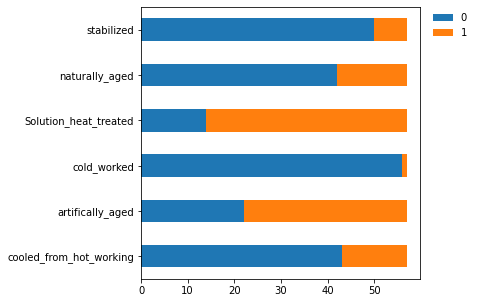

In [160]:
plot_df = X[['cooled_from_hot_working','artifically_aged','cold_worked','Solution_heat_treated','naturally_aged','stabilized']].astype(int)
ax = plot_df.apply(lambda x: x.value_counts()).T.plot(kind='barh', stacked=True,figsize=(5,5))
ax.legend(bbox_to_anchor=(1.2, 1.01), loc='upper right',frameon=False)

### Composition Distributions

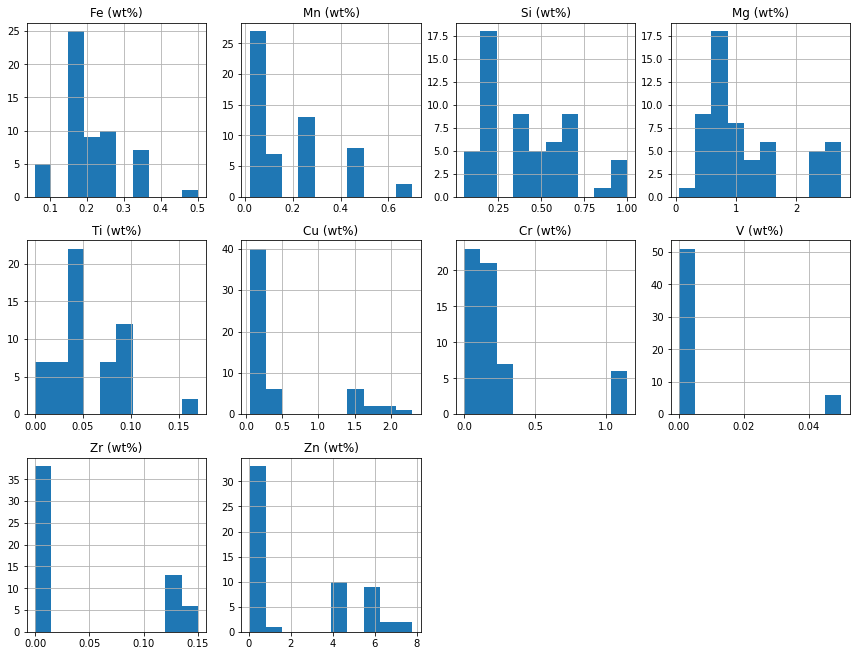

In [161]:
X.hist(figsize=(12, 12),layout=(4,4))
plt.tight_layout()    
plt.show()

### Distribution of the variables to be predicted

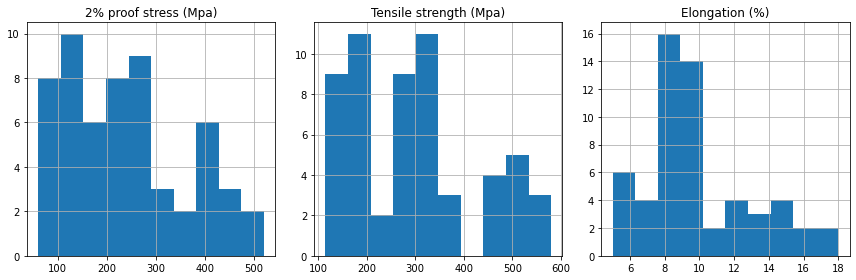

In [162]:
Y.hist(figsize=(12, 4),layout=(1,3))
plt.tight_layout()    
plt.show()

## 2. Prediction

For the different models that we would like to try we want to see how good the fit is to the real data, the below code does this by generating 3 plots for each of the variables.

In [163]:
from sklearn.metrics import mean_squared_error

def prediction_plots(pred_yield, pred_UTS, pred_elong, real_yield, real_UTS, real_elong, caption):
    fig, axs = plt.subplots(1, 3,figsize=(10,20))
    
    axs[0].scatter(real_yield,pred_yield)
    axs[1].scatter(real_UTS,pred_UTS)
    axs[2].scatter(real_elong,pred_elong)
    
    # Set the axis equal with a y=x line
    lims_yield = [np.min([axs[0].get_xlim(), axs[0].get_ylim()]), np.max([axs[0].get_xlim(), axs[0].get_ylim()])]
    lims_UTS   = [np.min([axs[1].get_xlim(), axs[1].get_ylim()]), np.max([axs[1].get_xlim(), axs[1].get_ylim()])]
    lims_Elong = [np.min([axs[2].get_xlim(), axs[2].get_ylim()]), np.max([axs[2].get_xlim(), axs[2].get_ylim()])]

    # yield strengths
    axs[0].plot(lims_yield, lims_yield, '0.8', alpha=0.5, zorder=0)
    axs[0].set_xlim(lims_yield)
    axs[0].set_ylim(lims_yield)
    axs[0].set_aspect('equal')
    
    # UTS
    axs[1].plot(lims_UTS, lims_UTS, '0.8', alpha=0.5, zorder=0)
    axs[1].set_xlim(lims_UTS)
    axs[1].set_ylim(lims_UTS)
    axs[1].set_aspect('equal')
    
    # Elongation
    axs[2].plot(lims_Elong, lims_Elong, '0.8', alpha=0.5, zorder=0)
    axs[2].set_xlim(lims_Elong)
    axs[2].set_ylim(lims_Elong)
    axs[2].set_aspect('equal')
    
    # Axis labelling
    axs[0].set(xlabel='True 2% proof stress (Mpa)', ylabel='Predicted 2% proof stress (Mpa)',
               title='MSE: '+'%s' % float('%.4g' % mean_squared_error(real_yield,pred_yield)))
    axs[1].set(xlabel='True Tensile strength (Mpa)', ylabel='Predicted Tensile strength (Mpa)',
               title='MSE: '+'%s' % float('%.4g' % mean_squared_error(real_UTS,pred_UTS)))
    axs[2].set(xlabel='True Elongation (%)', ylabel='Predicted Elongation (%)',
               title='MSE: '+'%s' % float('%.4g' % mean_squared_error(real_elong,pred_elong)))
    
    # add a figure caption
    fig.text(0.5, 0.38, caption, wrap=True, horizontalalignment='center', fontsize=12)
    
    fig.tight_layout()    
    plt.show()
    return 

### Linear Regression

Lets start off by just using basic linear regression with a test train split.

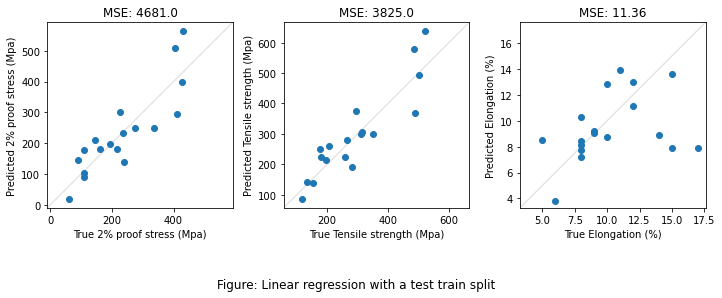

In [164]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Y_yield = Y['2% proof stress (Mpa)' ]
Y_UTS   = Y['Tensile strength (Mpa)']
Y_elong = Y['Elongation (%)'        ]

X_yield_train, X_yield_test, Y_yield_train, Y_yield_test = train_test_split(X,Y_yield,test_size=0.3,random_state=101)
X_UTS_train, X_UTS_test, Y_UTS_train, Y_UTS_test         = train_test_split(X,Y_UTS  ,test_size=0.3,random_state=101)
X_elong_train, X_elong_test, Y_elong_train, Y_elong_test = train_test_split(X,Y_elong,test_size=0.3,random_state=101)

model1_yield = LinearRegression().fit(X_yield_train, Y_yield_train)
model1_UTS   = LinearRegression().fit(X_UTS_train  , Y_UTS_train  )
model1_elong = LinearRegression().fit(X_elong_train, Y_elong_train)

caption = 'Figure: Linear regression with a test train split'
prediction_plots(model1_yield.predict(X_yield_test),
                 model1_UTS.predict(X_UTS_test  ),
                 model1_elong.predict(X_elong_test),
                 Y_yield_test,Y_UTS_test,Y_elong_test,caption)

We can see here that because our dataset is small we don't get a good idea of how it captures all the behaviour. A way to solve this is using the leave one out method. For every row of the dataset a model will be trained using all the data excluding that row. This model is then used to make predictions for this row. This lets us use as much of the data as we can and is possible here due to the smaller size of the dataset. We'll use this method for all the models from here so let's make a function for that.

In [165]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict

def cross_val_leave_one_out(model,dataset):
    
    # Preidict the outputs
    Preidicted_yield = cross_val_predict(model, X, Y_yield,cv=LeaveOneOut(), n_jobs=-1)
    Preidicted_UTS   = cross_val_predict(model, X, Y_UTS  ,cv=LeaveOneOut(), n_jobs=-1)
    Preidicted_elong = cross_val_predict(model, X, Y_elong,cv=LeaveOneOut(), n_jobs=-1)
    
    # Calculate the MSE for each
    yield_MSE = mean_squared_error(Y_yield,Preidicted_yield)
    UTS_MSE   = mean_squared_error(Y_UTS  ,Preidicted_UTS  )
    elong_MSE = mean_squared_error(Y_elong,Preidicted_elong)
    
    # Output formatting
    predicted_values = pd.DataFrame(data=np.array([Preidicted_yield,Preidicted_UTS,Preidicted_elong]).T, columns=['yield','UTS','elong'])
    predicted_MSE    = pd.DataFrame(data=np.array([str(model),yield_MSE,UTS_MSE,elong_MSE],ndmin=2), columns=['model','yield_MSE','UTS_MSE','elong_MSE'])
    return predicted_values, predicted_MSE

linear_reg_values, linear_reg_MSE = cross_val_leave_one_out(LinearRegression(),X)

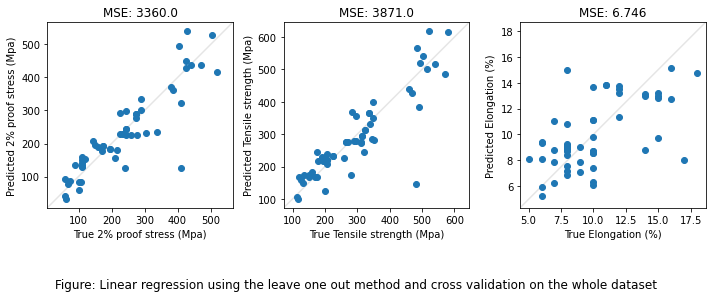

In [166]:
caption = 'Figure: Linear regression using the leave one out method and cross validation on the whole dataset'
prediction_plots(linear_reg_values['yield'],
                 linear_reg_values['UTS'],
                 linear_reg_values['elong'],
                 Y_yield,Y_UTS,Y_elong,caption)

We can see much more improvment from using a larger training set. However, the model is still poor at predicting elongation and could likely be further improved by using different methods. 

### Linear Regression + Normalisation

The first thing to try is to scale and normalise our data. While our values are all on a similar order of magnitude this may give us an improvment. 

In [167]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

X_norm = X.copy()

# normalisation
transformer = Normalizer().fit(X_norm)
X_norm = transformer.transform(X_norm)

# scaling
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X_norm)

# Predict
linear_reg_norm_values, linear_reg_norm_MSE = cross_val_leave_one_out(LinearRegression(),X_norm)

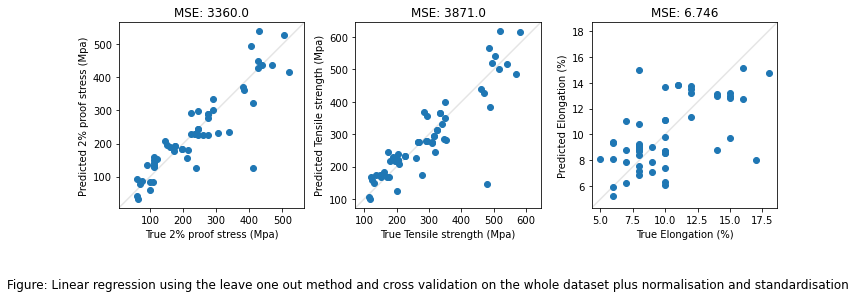

In [168]:
caption = 'Figure: Linear regression using the leave one out method and cross validation on the whole dataset plus normalisation and standardisation'
prediction_plots(linear_reg_norm_values['yield'],
                 linear_reg_norm_values['UTS'],
                 linear_reg_norm_values['elong'],
                 Y_yield,Y_UTS,Y_elong,caption)

No improvment is seen after scaling and so we will continue to use the unnormalised dataset.

### Descision Trees

Next let's try a descision tree, as alot of our data when it comes to processing is True/False this may be a powerful method and explainable method for capturing the behaviour. For this first model let's just use one descision tree regressor. 

In [169]:
from sklearn.tree import DecisionTreeRegressor

# predict
descision_tree_values, descision_tree_MSE = cross_val_leave_one_out(DecisionTreeRegressor(),X)

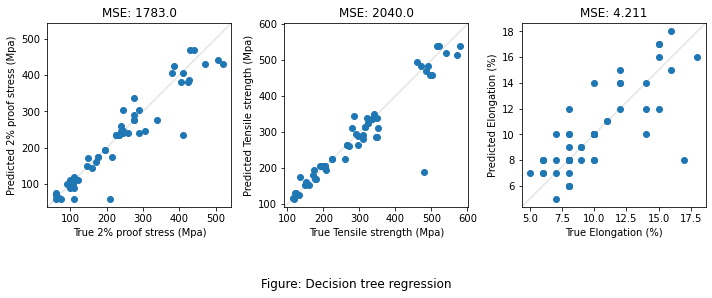

In [170]:
caption = 'Figure: Decision tree regression'
prediction_plots(descision_tree_values['yield'],
                 descision_tree_values['UTS'],
                 descision_tree_values['elong'],
                 Y_yield,Y_UTS,Y_elong,caption)

We can see that we already have a big improvement, we can furthr improve on this by not using just one tree but using many in a random forest. 

In [171]:
from sklearn.ensemble import RandomForestRegressor

# predict
random_forest_values, random_forest_MSE = cross_val_leave_one_out(DecisionTreeRegressor(),X)

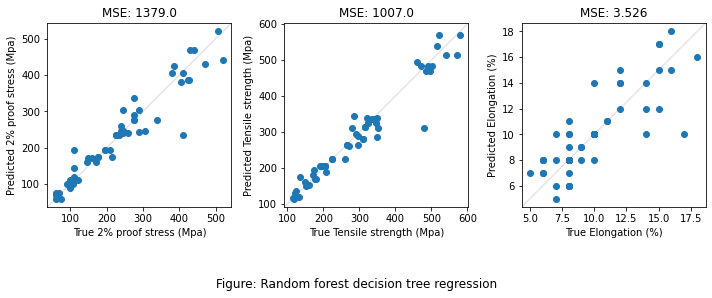

In [174]:
caption = 'Figure: Random forest decision tree regression'
prediction_plots(random_forest_values['yield'],
                 random_forest_values['UTS'],
                 random_forest_values['elong'],
                 Y_yield,Y_UTS,Y_elong,caption)

One last thing we can try is to use an even more advanced method based on trees xgboost.

In [175]:
from xgboost import XGBRegressor

# predict
xgboost_values, xgboost_MSE = cross_val_leave_one_out(XGBRegressor(),X)

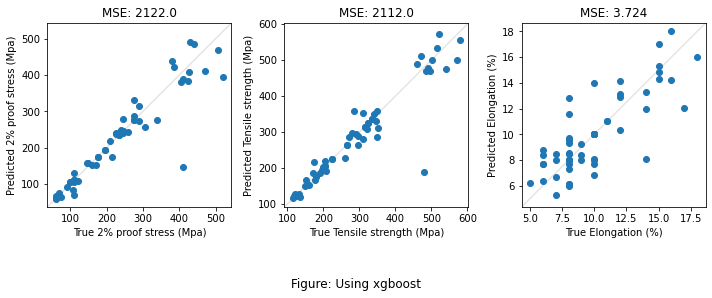

In [176]:
caption = 'Figure: Using xgboost'
prediction_plots(xgboost_values['yield'],
                 xgboost_values['UTS'],
                 xgboost_values['elong'],
                 Y_yield,Y_UTS,Y_elong,caption)

### Neural Networks
Going with the general rule that the layers contain 2/3 as many neurons as variables in the dataset

In [186]:
from sklearn.neural_network import MLPRegressor

# model
NN1 = MLPRegressor()

# predict
NN1_values, NN1_MSE = cross_val_leave_one_out(NN1,X)

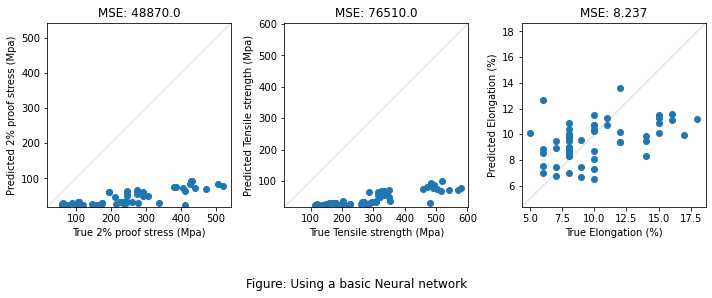

In [187]:
caption = 'Figure: Using a basic Neural network'
prediction_plots(NN1_values['yield'],
                 NN1_values['UTS'],
                 NN1_values['elong'],
                 Y_yield,Y_UTS,Y_elong,caption)

This model shows poor results, it most likely needs hyerparameter tuning. Due to how bad it is it will be left out of the comparison. 

## 3. Comparing and Conclusion

Finally lets compare these simple methods. We found that the best method was the random forest, this aligns with the finding int the paper. The results weren't as good as in the paper. This is most likely due to the need to optimise the hyperparameters in the models. 